In [1]:
!pip install wand

!apt install imagemagick

!pip install myqlm

!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 KB 10.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:


We are looking for a Hamiltonian such that the ground state minimizes the following cost function $C$: for every edge $(i,j)\in E$, and if the system is in the state $x$
- if $i,j\in V$ belong to the same subset, then $C_{(i,j)}(x) = 1$
- if $i,j\in V$ belong to different subsets, then $C_{(i,j)}(x)=-1$

(indeed we see that the cost function will be minimised if the number of edges with vertices in different subset is maximal, i.e. for the solution of MaxCUT)

The total cost for configuration $x$ will then be: $$C(x) = \sum_{(i,j)\in V}C_{(i,j)}(x)$$
We can notice that:
$$\langle x|\sigma_z^i\otimes\sigma_z^j|x\rangle = (1-2x_i)(1-2x_j)=
\left\{
\begin{array}[c&c]\\
1 & \text{if }\:x_i,x_j\in S\:\text{ or }\: x_i,x_j\in V\backslash S \\ -1 & \text{if }\:(x_i\in S \text{ and }x_j\in V\backslash S)\:\text{ or }\: (x_i\in V\backslash S\text{ and }x_j\in S)
\end{array}
\right.$$
Then :
$$\langle x|\sigma_z^i\otimes\sigma_z^j|x\rangle = C_{(i,j)}(x)$$
So we take for the Hamiltonian:
$$H=\sum_{(i,j)\in E}\sigma_z^i\otimes\sigma_z^j$$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [18]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0 # we initialize the value of cost function at 0
    for edge in edges:
      val += (1-2*b[edge[0]])*(1-2*b[edge[1]]) # we use the value defines previously : C_(i,j)(x) = (1-2x_i)(1-2x_j)
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

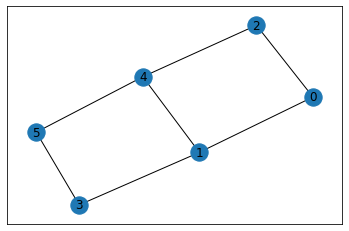

In [3]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [4]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [5]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [7]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer

    # RX layer
    for i in range(n_qubits):
      layer.apply(RX(theta), i) # we apply an RX gate on each qubit
    
    # Hc layer
    for edge in edges:
      layer.apply(U_ZZ(beta),[edge[0], edge[1]]) # for each edge, we apply a Uzz gate on qubits with indices the vertices of the edge
    # NB: there might be a more clever way to implement this, using only one for loop but I haven't found it as the gates don't commute
    
    return layer

### Question 4

In [16]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    # Initialization: apply hadamard on avery qubit
    for i in range(n_qubits):
      prog.apply(H, qubits[i]) 

    # Parametrized circuit
    for k in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*k], parameters[2*k+1]), qubits) # The parameters list is s.t.: [theta_0, beta_0, theta_1, beta_1, ..., theta_n-1, beta_n-1]
        
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        h=0
        for edge in edges:
          if sample.state.bitstring[edge[0]]==sample.state.bitstring[edge[1]]:
            h+=1
          else:
            h+=-1
        obs+=h*sample.probability # obs is thus the mean value of the hamiltonian at the end of the circuit

    # END TODO
    return obs
    
        

In [13]:
import numpy as np
np.random.random(3)

array([0.36575342, 0.98627434, 0.60536478])

In [14]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question: 5 layers

-1.2399621374103265 -3.28121037508 -3.4173007816021888 -3.6340238293566114 -3.8947813687137334 -3.926313670669983 -3.970151202612896 -3.9782384449993615 -3.9782688609845156 -3.978269014957226 -3.9782690296563343 -1.4407265395583302 -1.451847541646837 -2.5484343469547475 -2.954726363100906 -3.0515187599222227 -3.1987612925137583 -3.4651251477075156 -3.623872892343376 -3.6643232278571065 -3.736521627491015 -3.8608460617899 -4.0157298155589105 -4.041709744432793 -4.054348965815402 -4.058564565862713 -4.06144570866983 -4.066512198797057 -4.074079065374659 -4.076808073087644 -4.076878478226559 -4.076897083306973 -4.076917631468875 -4.076918648666219 -4.0769190196758 -4.076919034861323 -4.07691903564084 -0.2941684810135995 -2.077241598301272 -2.6646465912477555 -2.859368423049084 -3.0981144116927952 -3.241407820412593 -3.3021373094307247 -3.396057846543986 -3.841540698009072 -3.9258523383745376 -4.043267061576488 -4.225034029330335 -4.397301495394395 -4.439044546174415 -4.44834414677629 -4.4

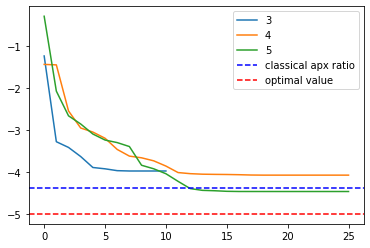

In [25]:
import matplotlib.pylab as plt


for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', linestyle='--', label="classical apx ratio")
plt.axhline(best_value,color='r', linestyle='--',label='optimal value')
plt.legend()

### Question 6: smart initialization

-0.5865303785794733 -0.7799188043902412 -2.0428021288560347 -2.1949539113514014 -2.4079779555359098 -2.435434442510773 -2.447517045103999 -2.4503615103968026 -2.587572074939725 -2.5892000230634977 -2.7346274295765203 -2.804730943698553 -2.9371940730502564 -3.1774781699869177 -3.5046528183284016 -3.5756696373765644 -3.5925488781269848 -3.5956945123801254 -3.5957380391085993 -3.5957440534357663 -3.5957440580195863 -3.595744058132095 -0.8481615373208959 -2.6624167651465576 -2.9512000846945 -3.428425394136267 -3.928932044270194 -3.963124095537636 -3.9704579800322253 -3.9821600559794126 -3.992179556591188 -3.9952143955898234 -4.000759388320073 -4.005014417887693 -4.00954614218852 -4.016302946539075 -4.051801037593082 -4.06755617675935 -4.080474945104796 -4.087253632639156 -4.097944419863505 -4.1062069374426535 -4.106859200007256 -4.107228187928724 -4.10723973959848 -4.107239788907408 -4.107239789096263 -2.9987620959215295 -3.215675713183913 -3.587659226017731 -3.9195279470033095 -3.98615259

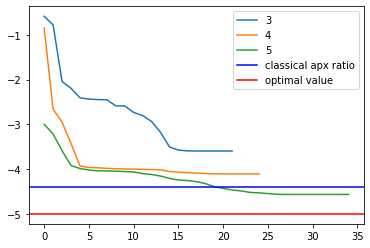

In [32]:
T = 100000.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    for k in range(1, nlayers+1):
      parameters_init.append((1-k/nlayers)*T/nlayers) # if we use the approximate value of the integral and put it in the exponential, this gives us the theoretical values of theta and beta
      parameters_init.append(T*k/nlayers**2)

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

This lowers the converging time of the algorithm